In [59]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

In [60]:
warnings.filterwarnings(action='ignore',category=FutureWarning)
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)

# Part 1 - Building up a basic predictive model

## Data cleaning and transformation

### Show the shape of the dataset

In [61]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("Manhattan12.csv", skiprows=4)
df.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART\nMENT\nNUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE\nPRICE,SALE DATE
0,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1306,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$2,214,693",20/05/2013
1,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1307,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,654,656",16/05/2013
2,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1308,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,069,162",23/05/2013
3,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1309,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,374,637",15/05/2013
4,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1310,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,649,565",13/05/2013


In [62]:
# Dtype conversion
df.columns = df.columns.str.strip().str.replace("\n", "")

def format_and_convert_column_to_numeric(col, dtype):
    df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)
    
format_and_convert_column_to_numeric('SALEPRICE', np.int64)
format_and_convert_column_to_numeric('GROSS SQUARE FEET', np.float64)
format_and_convert_column_to_numeric('LAND SQUARE FEET', np.float64)
format_and_convert_column_to_numeric('RESIDENTIAL UNITS', np.int64)
format_and_convert_column_to_numeric('TOTAL UNITS', np.int64)

# Convert To datetime
df['SALE DATE'] =pd.to_datetime(df['SALE DATE'], dayfirst=True)

df['YEAR BUILT'] = df['YEAR BUILT'].astype(np.int64)

In [63]:
df.columns = df.columns.str.replace("\n", "").str.replace(" ", "_")
df.rename(columns={"SALEPRICE": "SALE_PRICE", "APARTMENTNUMBER": "APARTMENT_NUMBER"}, inplace=True)
df.columns = df.columns.str.lower()

In [64]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()

In [65]:
df[categorical] = df[categorical].apply(lambda x: x.str.strip())
df.replace("", np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
df.isna().sum() / len(df) * 100

borough                             0.000000
neighborhood                        0.062055
building_class_category            12.608140
tax_class_at_present                0.521993
block                               0.000000
lot                                 0.000000
ease-ment                         100.000000
building_class_at_present           0.521993
address                             0.000000
apartment_number                   53.184888
zip_code                            0.003650
residential_units                  59.762730
commercial_units                   87.468516
total_units                        35.422522
land_square_feet                   83.613798
gross_square_feet                  84.208797
year_built                         23.511590
tax_class_at_time_of_sale           0.000000
building_class_at_time_of_sale      0.000000
sale_price                         27.716737
sale_date                           0.000000
dtype: float64

In [66]:
df.dropna(subset=['year_built'], how='any', inplace=True)

In [67]:
df['sale_year'] = pd.DatetimeIndex(df.sale_date).year
df['sale_month'] = pd.DatetimeIndex(df.sale_date).month
df['building_age'] = 2013 - df['year_built']

In [68]:
df.drop(columns=['borough', 'address', 'ease-ment', 'apartment_number', 'sale_date', 'year_built'], inplace=True)


In [69]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['neighborhood', 'building_class_category', 'tax_class_at_present', 'building_class_at_present', 'building_class_at_time_of_sale']
Numerical columns:  ['block', 'lot', 'zip_code', 'residential_units', 'commercial_units', 'total_units', 'land_square_feet', 'gross_square_feet', 'tax_class_at_time_of_sale', 'sale_price', 'sale_year', 'sale_month', 'building_age']


In [70]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,sale_price,sale_year,sale_month,building_age
count,20954.000000,20954.000000,20954.000000,8624.000000,3274.000000,11738.000000,4320.000000,4.319000e+03,20954.000000,1.628700e+04,20954.000000,20954.000000,20954.000000
mean,1125.502338,568.544669,10029.774363,5.295686,3.088577,4.808059,5923.381481,6.063457e+04,2.282285,2.788147e+06,2012.532500,7.153002,59.919443
std,492.073441,791.773978,35.391957,26.154578,12.986706,23.759930,7877.044375,8.116691e+04,0.748000,2.095445e+07,0.498955,3.465957,37.692641
min,7.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,469.000000,2.530000e+02,1.000000,1.000000e+00,2012.000000,1.000000,0.000000
25%,851.000000,27.000000,10014.000000,1.000000,1.000000,1.000000,2093.750000,6.196000e+03,2.000000,4.230000e+05,2012.000000,4.000000,26.000000
50%,1140.000000,52.000000,10021.000000,1.000000,2.000000,1.000000,5508.000000,2.331000e+04,2.000000,7.700000e+05,2013.000000,7.000000,58.000000
75%,1444.000000,1111.000000,10028.000000,1.000000,2.000000,2.000000,7532.000000,1.128500e+05,2.000000,1.675000e+06,2013.000000,10.000000,93.000000
max,2250.000000,9117.000000,10463.000000,1328.000000,604.000000,1349.000000,213650.000000,1.970736e+06,4.000000,1.307965e+09,2013.000000,12.000000,1013.000000


In [71]:
min_values = df[numerical].min()

In [72]:
df['sale_price'].describe()

count    1.628700e+04
mean     2.788147e+06
std      2.095445e+07
min      1.000000e+00
25%      4.230000e+05
50%      7.700000e+05
75%      1.675000e+06
max      1.307965e+09
Name: sale_price, dtype: float64

In [73]:
df = df[(df['sale_price'] > 1000000) & (df['sale_price'] < 15000000)]

In [74]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,sale_price,sale_year,sale_month,building_age
count,6045.000000,6045.000000,6045.000000,3344.000000,581.000000,3645.000000,1082.000000,1083.00000,6045.000000,6.045000e+03,6045.000000,6045.000000,6045.000000
mean,1079.670802,657.608933,10032.020017,4.878289,2.146299,4.840604,3879.049908,14316.78855,2.072953,2.953994e+06,2012.563441,7.016212,66.419024
std,523.603950,847.593720,41.107486,11.415722,2.617107,11.280920,5695.414442,28726.70133,0.502283,2.395043e+06,0.496000,3.339008,37.920455
min,11.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,469.000000,999.00000,1.000000,1.001000e+06,2012.000000,1.000000,0.000000
25%,698.000000,28.000000,10013.000000,1.000000,1.000000,1.000000,1833.000000,4441.50000,2.000000,1.400000e+06,2012.000000,4.000000,30.000000
50%,1170.000000,69.000000,10022.000000,1.000000,1.000000,1.000000,2421.500000,7677.00000,2.000000,2.008000e+06,2013.000000,7.000000,83.000000
75%,1433.000000,1164.000000,10028.000000,1.000000,2.000000,2.000000,3909.000000,13732.50000,2.000000,3.500000e+06,2013.000000,10.000000,98.000000
max,2246.000000,9008.000000,10463.000000,188.000000,47.000000,195.000000,88940.000000,538213.00000,4.000000,1.490000e+07,2013.000000,12.000000,213.000000


In [75]:
df.dropna(subset=categorical, how='any', inplace=True)

In [76]:
df.drop_duplicates(inplace=True)

In [77]:
df.drop(columns=['building_class_at_present', 'tax_class_at_present', 'tax_class_at_time_of_sale', 'building_class_at_time_of_sale', 'total_units'], inplace=True)

In [78]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['neighborhood', 'building_class_category']
Numerical columns:  ['block', 'lot', 'zip_code', 'residential_units', 'commercial_units', 'land_square_feet', 'gross_square_feet', 'sale_price', 'sale_year', 'sale_month', 'building_age']


<AxesSubplot: >

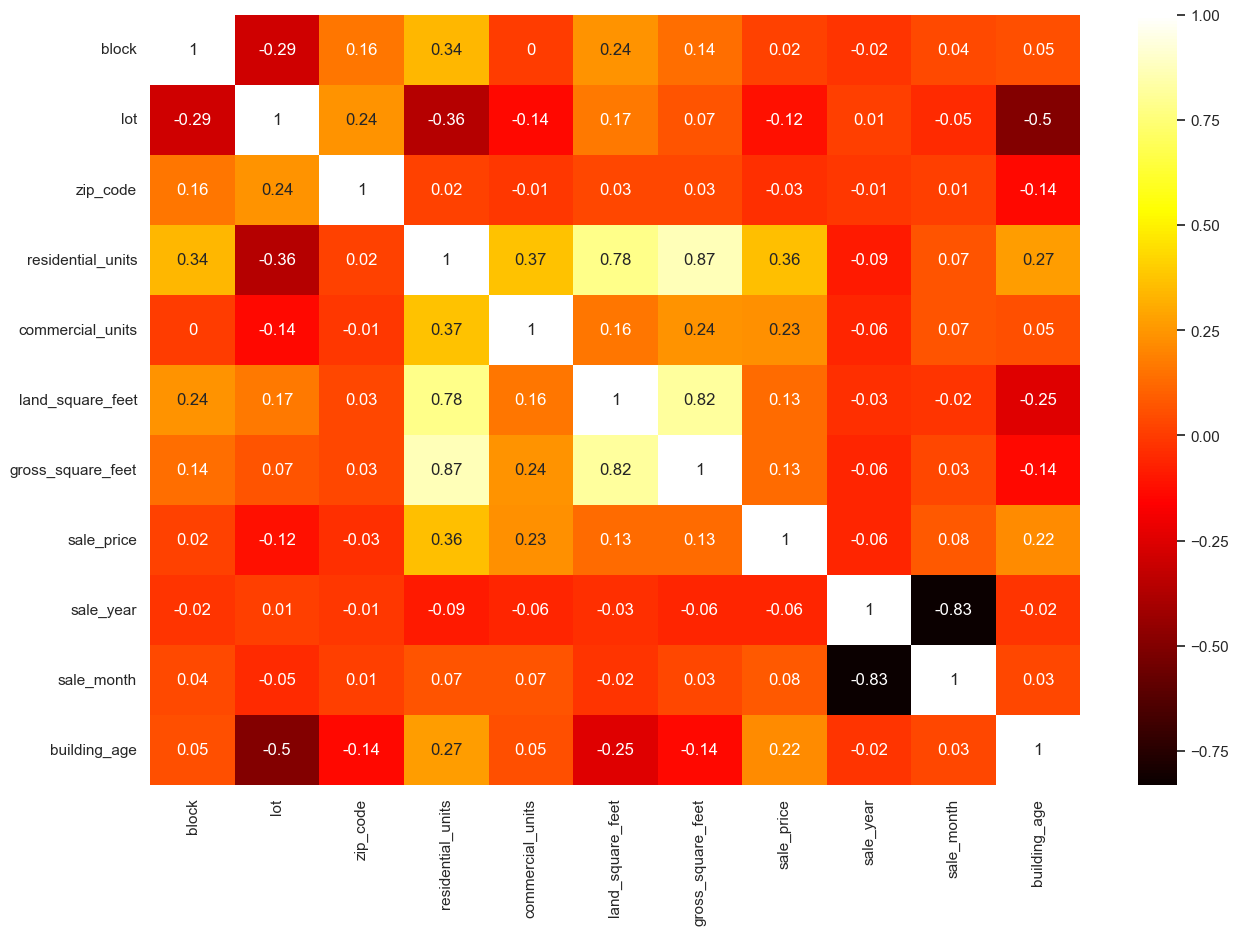

In [79]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical].corr().round(2), annot=True, cmap='hot')

In [80]:
X = df.drop(columns='sale_price')
y = df['sale_price']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5959 entries, 18 to 27386
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   neighborhood             5959 non-null   object 
 1   building_class_category  5959 non-null   object 
 2   block                    5959 non-null   int64  
 3   lot                      5959 non-null   int64  
 4   zip_code                 5959 non-null   float64
 5   residential_units        3329 non-null   float64
 6   commercial_units         577 non-null    float64
 7   land_square_feet         1076 non-null   float64
 8   gross_square_feet        1077 non-null   float64
 9   sale_year                5959 non-null   int64  
 10  sale_month               5959 non-null   int64  
 11  building_age             5959 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 605.2+ KB


In [81]:
neigborhood_le = LabelEncoder()
building_class_category_le = LabelEncoder()
X['encoded_neighborhood'] = neigborhood_le.fit_transform(X['neighborhood'])
X['encoded_building_class_category'] = building_class_category_le.fit_transform(X['building_class_category'])
X.drop(columns=['building_class_category', 'neighborhood'], inplace=True)
final_columns = X.columns

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [83]:
X_test = pd.DataFrame(X_test, columns=final_columns)
X_train = pd.DataFrame(X_train, columns=final_columns)

In [84]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [85]:
final_columns = train.columns

In [86]:
train.isnull().sum()

block                                 0
lot                                   0
zip_code                              0
residential_units                  2117
commercial_units                   4293
land_square_feet                   3889
gross_square_feet                  3887
sale_year                             0
sale_month                            0
building_age                          0
encoded_neighborhood                  0
encoded_building_class_category       0
sale_price                            0
dtype: int64

In [87]:
le = LinearRegression()
imputer = IterativeImputer(estimator=le, min_value=train.min())
imputer.fit(train)
train = pd.DataFrame(imputer.transform(train), columns=final_columns)
test = pd.DataFrame(imputer.transform(test), columns=final_columns)

In [88]:
train[['commercial_units', 'residential_units']] = train[['commercial_units', 'residential_units']].applymap(lambda x: round(x))
test[['commercial_units', 'residential_units']] = test[['commercial_units', 'residential_units']].applymap(lambda x: round(x))

In [89]:
train.describe()

,block,lot,zip_code,residential_units,commercial_units,land_square_feet,gross_square_feet,sale_year,sale_month,building_age,encoded_neighborhood,encoded_building_class_category,sale_price
count,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4.767000e+03
mean,1083.113069,638.418083,10031.680092,7.213551,1.258863,3504.479469,7261.993952,2012.560940,7.022236,66.642752,22.226348,8.478288,2.939077e+06
std,520.291569,827.922330,40.157890,13.444315,1.017943,2755.842545,14276.652131,0.496325,3.335916,37.873158,11.157597,3.465177,2.379934e+06
min,11.000000,1.000000,10001.000000,1.000000,1.000000,469.000000,999.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,1.001000e+06
25%,714.000000,27.000000,10013.000000,1.000000,1.000000,2443.879361,999.000000,2012.000000,4.000000,30.000000,11.000000,7.000000,1.400000e+06
50%,1171.000000,67.000000,10022.000000,4.000000,1.000000,3365.868934,5233.000000,2013.000000,7.000000,83.000000,27.000000,7.000000,2.000000e+06
75%,1441.500000,1161.000000,10028.000000,10.000000,1.000000,4163.000000,10723.424872,2013.000000,10.000000,98.000000,31.000000,10.000000,3.500000e+06
max,2246.000000,5774.000000,10463.000000,480.000000,47.000000,88940.000000,538213.000000,2013.000000,12.000000,167.000000,37.000000,28.000000,1.490000e+07


In [90]:
test.describe()

,block,lot,zip_code,residential_units,commercial_units,land_square_feet,gross_square_feet,sale_year,sale_month,building_age,encoded_neighborhood,encoded_building_class_category,sale_price
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1.192000e+03
mean,1072.533557,697.554530,10033.433725,6.815436,1.244128,3504.321044,6827.306941,2012.566275,7.019295,66.031040,22.566275,8.660235,2.985497e+06
std,534.188823,905.897379,44.258105,9.303602,0.690562,2048.363519,8758.958652,0.495796,3.334998,37.684535,11.082348,3.349423,2.431052e+06
min,16.000000,1.000000,10001.000000,1.000000,1.000000,469.000000,999.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,1.005000e+06
25%,624.000000,29.000000,10013.000000,1.000000,1.000000,2488.580535,999.000000,2012.000000,4.750000,30.000000,11.000000,7.000000,1.410000e+06
50%,1171.000000,91.000000,10022.000000,2.500000,1.000000,3371.247095,3808.327158,2013.000000,7.000000,83.000000,27.000000,10.000000,2.050000e+06
75%,1428.250000,1168.250000,10028.000000,10.000000,1.000000,4123.429584,10648.736458,2013.000000,10.000000,98.000000,31.000000,10.000000,3.492500e+06
max,2180.000000,9008.000000,10282.000000,92.000000,8.000000,37305.000000,107701.000000,2013.000000,12.000000,213.000000,37.000000,26.000000,1.400000e+07


In [91]:
train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, '7.0'),
  Text(1, 0, '25.0'),
  Text(2, 0, '23.0'),
  Text(3, 0, '18.0'),
  Text(4, 0, '12.0'),
  Text(5, 0, '32.0'),
  Text(6, 0, '9.0'),
  Text(7, 0, '35.0'),
  Text(8, 0, '24.0'),
  Text(9, 0, '3.0'),
  Text(10, 0, '21.0'),
  Text(11, 0, '1.0'),
  Text(12, 0, '34.0'),
  Text(13, 0, '10.0'),
  Text(14, 0, '8.0'),
  Text(15, 0, '28.0'),
  Text(16, 0, '26.0'),
  Text(17, 0, '13.0'),
  Text(18, 0, '33.0'),
  Text(19, 0, '31.0'),
  Text(20, 0, '4.0'),
  Text(21, 0, '29.0'),
  Text(22, 0, '20.0'),
  Text(23, 0, '30.0'),
  Text(24, 0, '6.0'),
  Text(25, 0, '2.0'),
  Text(26, 0, '19.0'),
  Text(27, 0, '16.0'),
  Text(28, 0, '11.0'),
  Text(29, 0, '17.0'),
  Text(30, 0, '27.0'),
  Text(31, 0, '5.0'),
  Text(32, 0, '14.0'),
  Text(33, 0, '36.0'),
  Text(34, 0, '37.0'),
  Text(35, 0, '22.0'),
  Text(36, 0,

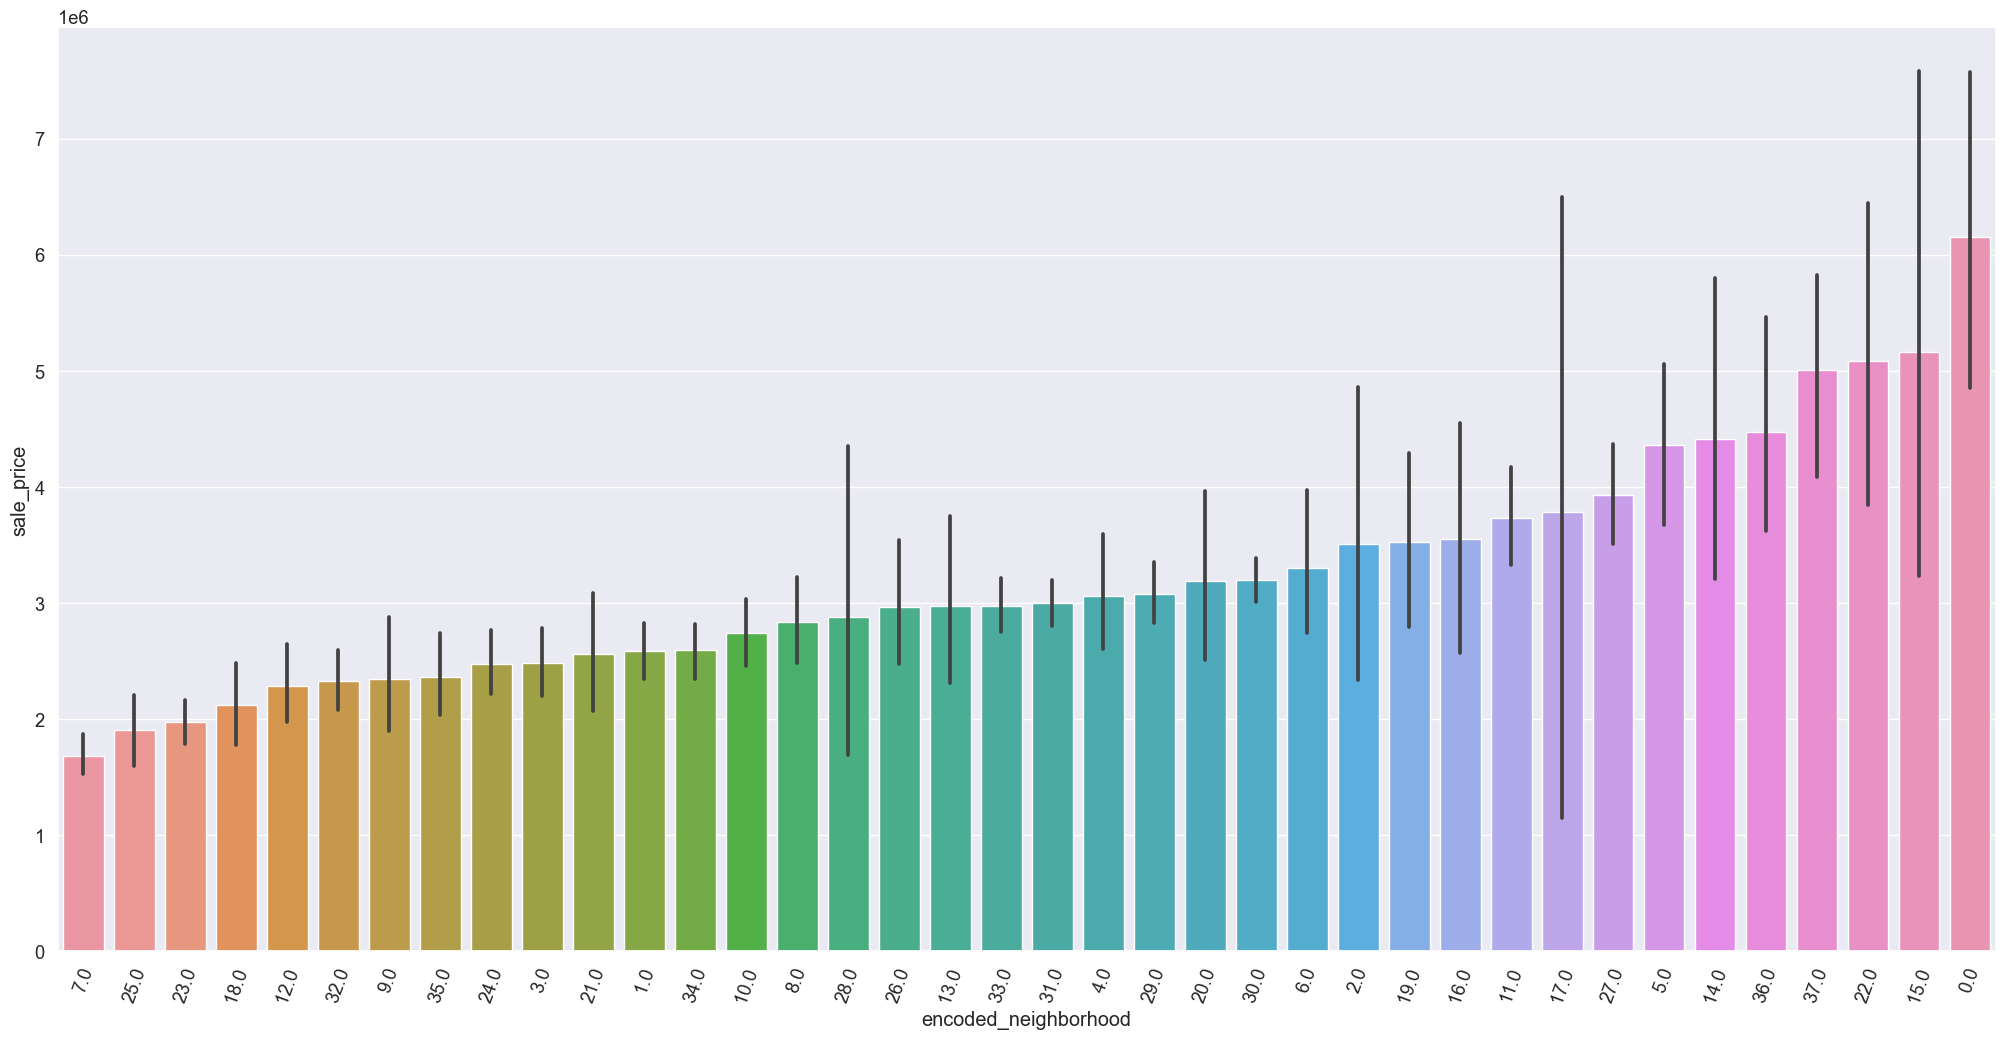

In [92]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
fig = sns.barplot(data=train ,y='sale_price', x='encoded_neighborhood', order=train.groupby(['encoded_neighborhood']).mean().sort_values('sale_price').index)
plt.xticks(rotation=70)

In [93]:
train['sale_price'] = np.log(train['sale_price'])
test['sale_price'] = np.log(test['sale_price'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, '7.0'),
  Text(1, 0, '23.0'),
  Text(2, 0, '9.0'),
  Text(3, 0, '12.0'),
  Text(4, 0, '25.0'),
  Text(5, 0, '18.0'),
  Text(6, 0, '35.0'),
  Text(7, 0, '24.0'),
  Text(8, 0, '21.0'),
  Text(9, 0, '34.0'),
  Text(10, 0, '28.0'),
  Text(11, 0, '32.0'),
  Text(12, 0, '1.0'),
  Text(13, 0, '10.0'),
  Text(14, 0, '3.0'),
  Text(15, 0, '26.0'),
  Text(16, 0, '13.0'),
  Text(17, 0, '8.0'),
  Text(18, 0, '33.0'),
  Text(19, 0, '31.0'),
  Text(20, 0, '4.0'),
  Text(21, 0, '30.0'),
  Text(22, 0, '2.0'),
  Text(23, 0, '20.0'),
  Text(24, 0, '29.0'),
  Text(25, 0, '6.0'),
  Text(26, 0, '11.0'),
  Text(27, 0, '16.0'),
  Text(28, 0, '19.0'),
  Text(29, 0, '17.0'),
  Text(30, 0, '14.0'),
  Text(31, 0, '27.0'),
  Text(32, 0, '36.0'),
  Text(33, 0, '5.0'),
  Text(34, 0, '22.0'),
  Text(35, 0, '15.0'),
  Text(36, 0,

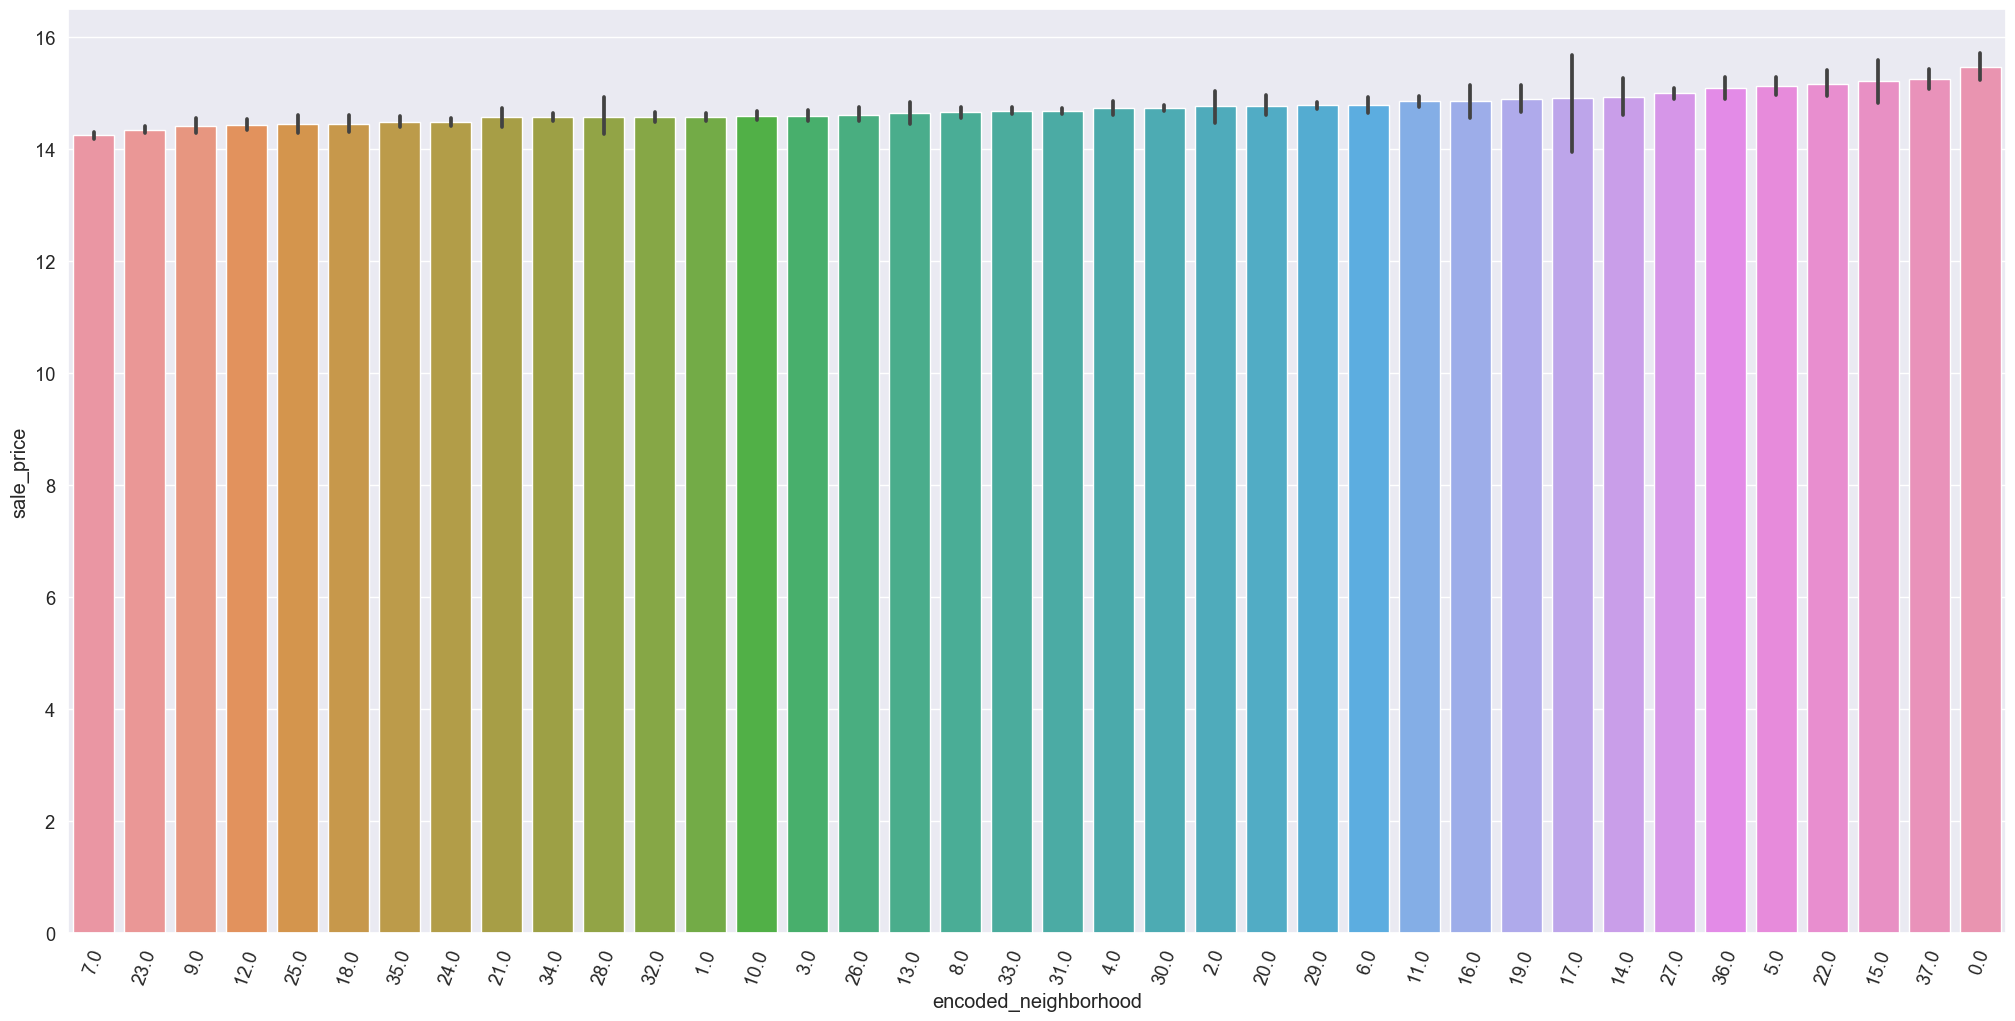

In [94]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
fig = sns.barplot(data=train ,y='sale_price', x='encoded_neighborhood', order=train.groupby(['encoded_neighborhood']).mean().sort_values('sale_price').index)
plt.xticks(rotation=70)

In [95]:
neigborhood_le.classes_

array(['ALPHABET CITY', 'CHELSEA', 'CHINATOWN', 'CIVIC CENTER', 'CLINTON',
       'EAST VILLAGE', 'FASHION', 'FINANCIAL', 'FLATIRON', 'GRAMERCY',
       'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST',
       'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'HARLEM-WEST',
       'INWOOD', 'JAVITS CENTER', 'KIPS BAY', 'LITTLE ITALY',
       'LOWER EAST SIDE', 'MANHATTAN VALLEY', 'MIDTOWN CBD',
       'MIDTOWN EAST', 'MIDTOWN WEST', 'MORNINGSIDE HEIGHTS',
       'MURRAY HILL', 'SOHO', 'SOUTHBRIDGE', 'TRIBECA',
       'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)',
       'UPPER EAST SIDE (96-110)', 'UPPER WEST SIDE (59-79)',
       'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)',
       'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER'],
      dtype=object)

<AxesSubplot: >

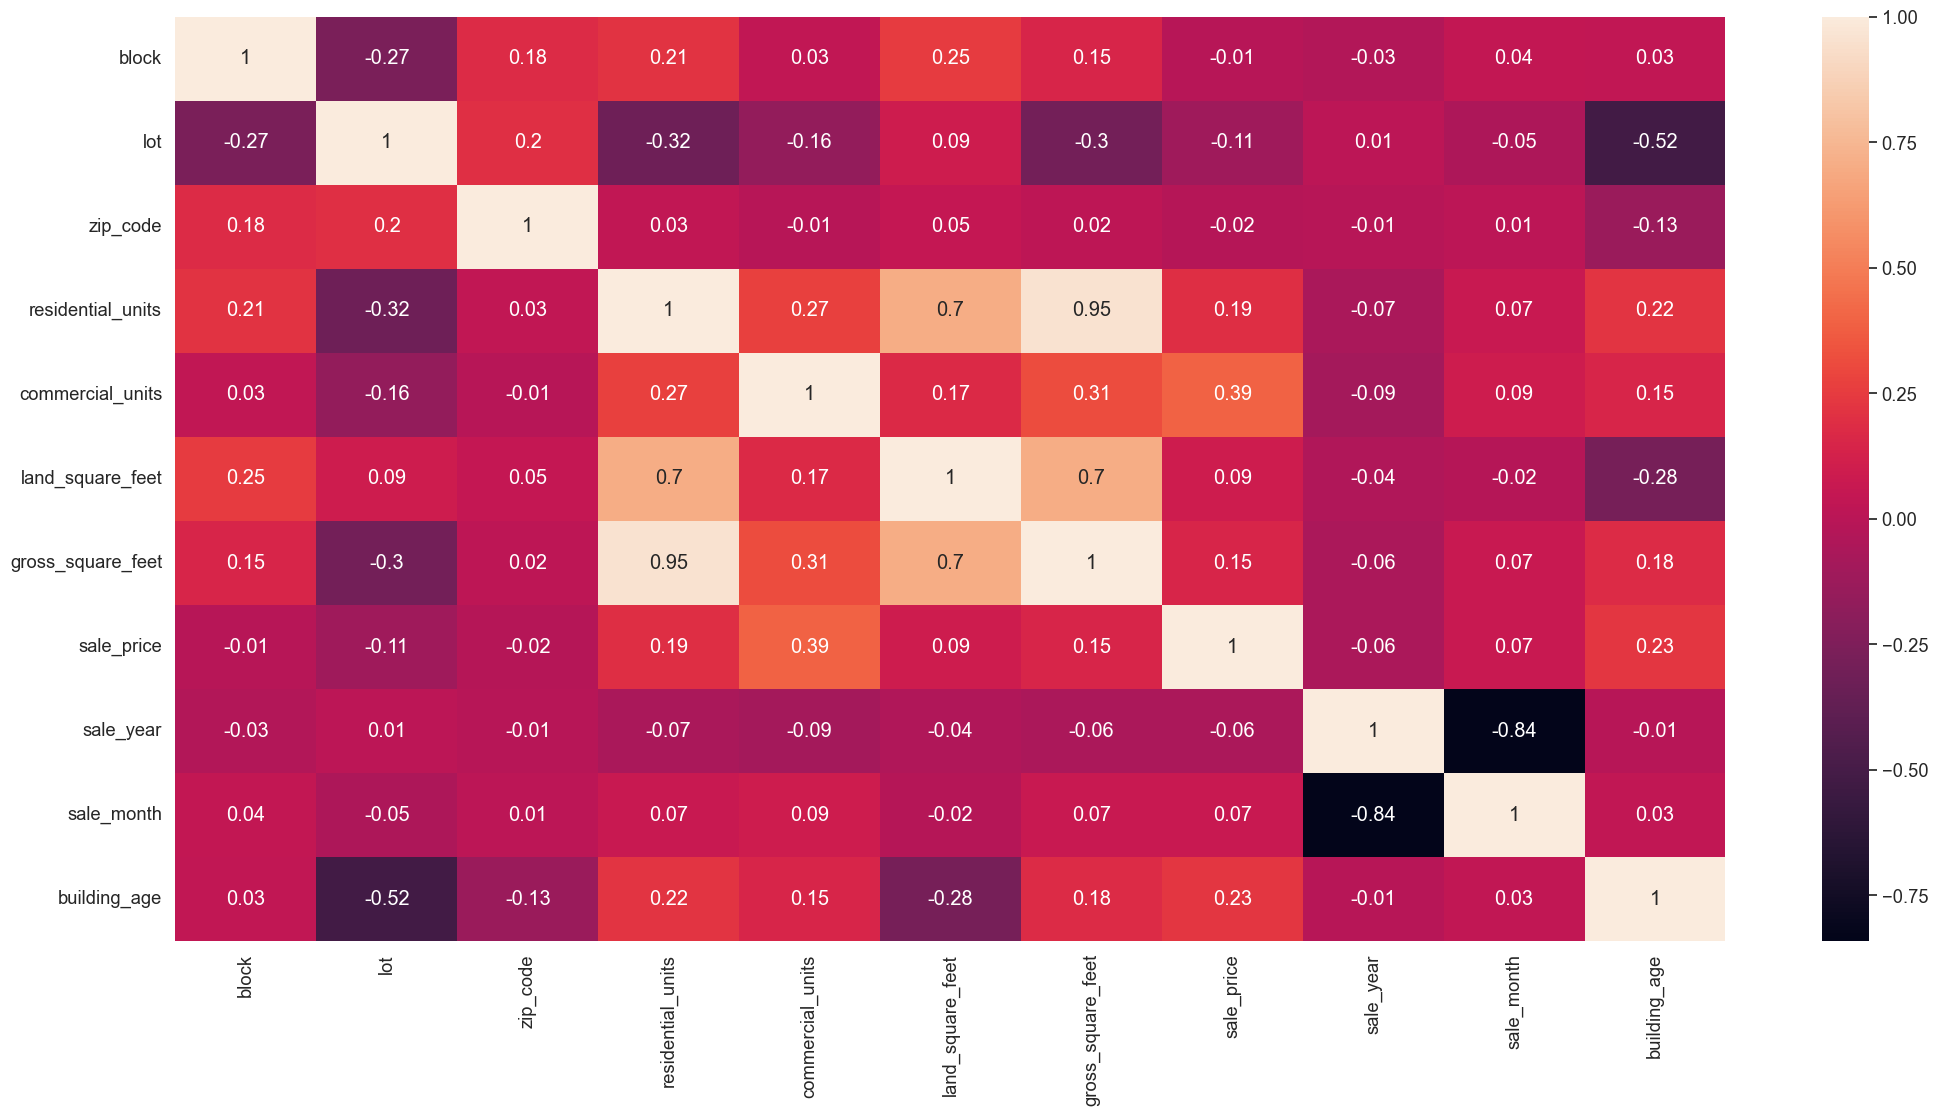

In [96]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
sns.heatmap(train[numerical].corr().round(2), annot=True)

In [97]:
train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.int)

In [98]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
train = train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]
'''
Zolduoarrati, E. (2019, December 17). Remove Outliers in Pandas DataFrame using Percentiles. Stack Overflow. https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
'''

'\nZolduoarrati, E. (2019, December 17). Remove Outliers in Pandas DataFrame using Percentiles. Stack Overflow. https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles\n'

In [99]:
numerical.extend(['encoded_neighborhood', 'encoded_building_class_category'])

In [100]:

standard_scaler = StandardScaler()
X_columns = X_train.columns

In [101]:
X_train_sc = standard_scaler.fit_transform(train.iloc[:, :-1])
X_train_sc

array([[ 0.25409367, -1.04661323,  0.55566606, ...,  0.70305848,
         1.0395563 , -0.75478673],
       [ 0.8208632 , -1.0081766 ,  0.32364109, ...,  0.62586013,
         0.77946635, -0.75478673],
       [-1.70548186,  0.67534761, -1.30053369, ..., -1.53569374,
        -1.56134324,  0.62526451],
       ...,
       [ 0.79674535, -1.06813774,  0.43965357, ..., -0.32625289,
         0.77946635, -0.75478673],
       [ 0.53345879,  0.64613577,  2.06382835, ..., -1.40702982,
         0.25928644,  0.62526451],
       [ 0.75051947, -1.02047632,  0.43965357, ..., -0.22332175,
         0.17258979, -0.75478673]])

In [102]:
X_train = pd.DataFrame(X_train_sc, columns=X_columns)

In [103]:
X_test_sc = standard_scaler.transform(test.iloc[:, :-1])
X_test = pd.DataFrame(X_test_sc, columns=X_columns)

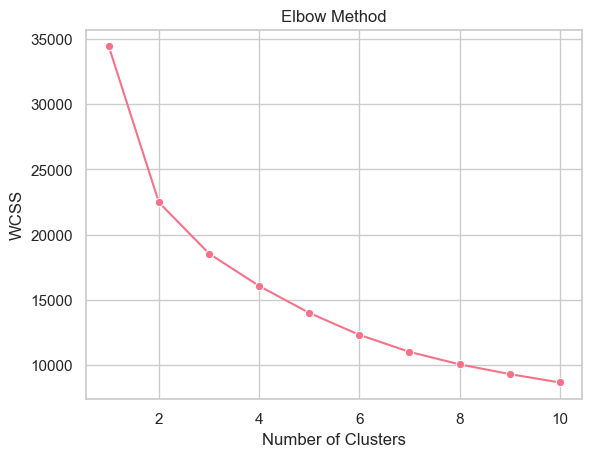

In [104]:
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook")

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=69420)
    kmeans.fit(X_train.values)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=range(1, 11), y=wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [105]:
number_of_clusters = 2

k_means_model = KMeans(n_clusters=number_of_clusters, random_state=69420, max_iter=500)

In [106]:
k_means_model.fit(X_train)

KMeans(max_iter=500, n_clusters=2, random_state=69420)

In [107]:
train_clusters = k_means_model.predict(X_train)

In [108]:
labels = k_means_model.labels_

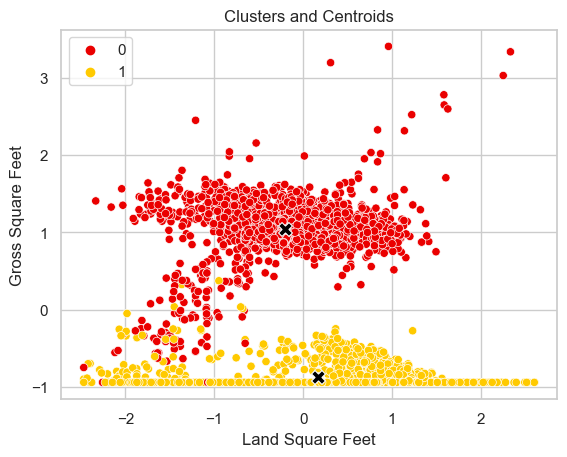

In [109]:
sns.scatterplot(x=X_train['land_square_feet'], y=X_train['gross_square_feet'], hue=k_means_model.labels_, palette='hot')

# add cluster centroids to the scatter plot
sns.scatterplot(x=k_means_model.cluster_centers_[:, 5], y=k_means_model.cluster_centers_[:, 6], color='black', marker='X', s=100)

plt.title('Clusters and Centroids')
plt.xlabel('Land Square Feet')
plt.ylabel('Gross Square Feet')
plt.show()

In [110]:
X_train_a = train[train_clusters == 0].iloc[:, :-1]
y_train_a = train[train_clusters == 0].iloc[:, -1]
X_train_b = train[train_clusters == 1].iloc[:, :-1]
y_train_b = train[train_clusters == 1].iloc[:, -1]

In [111]:
regressor_a = LinearRegression()
regressor_b = LinearRegression()

regressor_a.fit(X_train_a, y_train_a)
regressor_b.fit(X_train_b, y_train_b)

LinearRegression()

In [112]:
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]
test_clusters = k_means_model.predict(X_test)

In [113]:
X_test_a = X_test[test_clusters == 0].values
y_test_a = y_test[test_clusters == 0].values
X_test_b = X_test[test_clusters == 1].values
y_test_b = y_test[test_clusters == 1].values

In [114]:
y_pred_a = regressor_a.predict(X_test_a)
y_pred_b = regressor_b.predict(X_test_b)

In [115]:

cluster_a_pred = pd.DataFrame(np.concatenate((y_test_a.reshape(-1, 1), y_pred_a.reshape(-1, 1)), axis=1), columns=['Y_TRUE', 'Y_PRED'])
cluster_b_pred = pd.DataFrame(np.concatenate((y_test_b.reshape(-1, 1), y_pred_b.reshape(-1, 1)), axis=1), columns=['Y_TRUE', 'Y_PRED'])
final_pred = pd.concat([cluster_a_pred, cluster_b_pred], axis=0)

In [116]:
mae = mean_absolute_error(final_pred.iloc[:, 0], final_pred.iloc[:, 1])
mse = mean_squared_error(final_pred.iloc[:, 0], final_pred.iloc[:, 1])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error - {mae}')
print(f'Mean Squared Error - {mse}')
print(f'Root Mean Squared Error - {rmse}')

Mean Absolute Error - 0.6392280906997616
Mean Squared Error - 0.7361911164493864
Root Mean Squared Error - 0.8580158019811677
